In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch

In [6]:
import os

DATA_DIR ='/kaggle/input/website-collection'
print(os.listdir(DATA_DIR))

['train_set']


In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

image_size = 64
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

# class ImageFolder(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.transform = transform
#         self.data = []
#         for image_name in os.listdir(root_dir):
#             self.data.append(root_dir+'/'+image_name)
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         data = self.data[index]
#         img = np.array(Image.open(data).convert('RGB'))
#         if self.transform:
#             augmentations = self.transform(image=img)
#             img = augmentations["image"]
        
#         img = torch.from_numpy(img)        
        
#         return img

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# image_size = 64
# batch_size = 128
# stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# A_transforms= A.Compose(
#     [
#         A.Resize(width=image_size, height=image_size),
#         A.HorizontalFlip(p=0.5),
#         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
#         A.OneOf([
#             A.Blur(blur_limit=3, p=0.5),
#             A.ColorJitter(p=0.5),
#         ], p=1.0),
#         A.Normalize(
#             mean=[0, 0, 0],
#             std=[1, 1, 1],
#             max_pixel_value=255,
#         ),
# #         ToTensorV2(),
#     ]
# )
# train_ds = ImageFolder("/kaggle/input/website-collection/train_set",transform=A_transforms)
# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
# # print(train_dataset[0].shape)

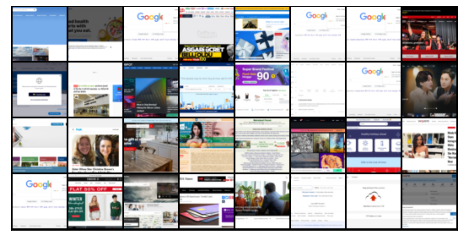

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images,_ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [14]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [15]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)


torch.Size([32, 3, 64, 64])


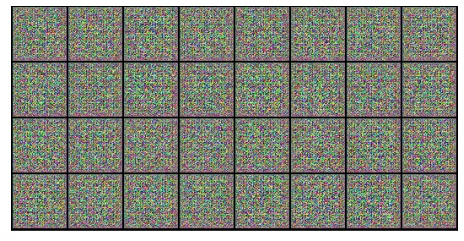

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Saving generated-images-0000.png


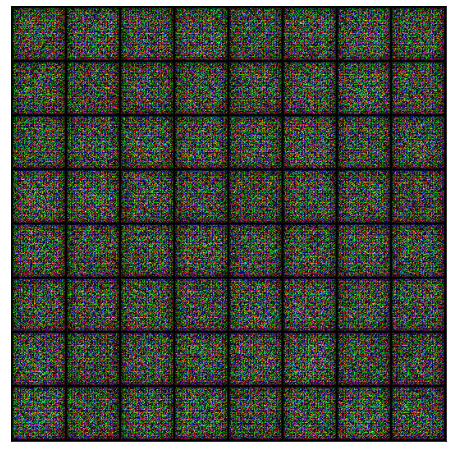

In [21]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [24]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [25]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [40]:
lr = 0.0002
epochs = 100

In [42]:
histo

ry = fit(epochs, lr)

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.6519, loss_d: 0.1939, real_score: 0.9807, fake_score: 0.1446
Saving generated-images-0001.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 3.6382, loss_d: 0.8197, real_score: 0.7741, fake_score: 0.2471
Saving generated-images-0002.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 1.4011, loss_d: 0.7656, real_score: 0.5909, fake_score: 0.1566
Saving generated-images-0003.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 2.9935, loss_d: 0.7506, real_score: 0.8847, fake_score: 0.3906
Saving generated-images-0004.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 4.7252, loss_d: 0.1177, real_score: 0.9031, fake_score: 0.0109
Saving generated-images-0005.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 6.3946, loss_d: 0.6074, real_score: 0.9578, fake_score: 0.3740
Saving generated-images-0006.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 3.4479, loss_d: 0.2329, real_score: 0.8333, fake_score: 0.0352
Saving generated-images-0007.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 5.5172, loss_d: 0.9994, real_score: 0.9856, fake_score: 0.5410
Saving generated-images-0008.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.3676, loss_d: 0.2976, real_score: 0.8657, fake_score: 0.1114
Saving generated-images-0009.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 5.4990, loss_d: 0.2580, real_score: 0.9783, fake_score: 0.1878
Saving generated-images-0010.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.5726, loss_d: 0.8608, real_score: 0.5758, fake_score: 0.0568
Saving generated-images-0011.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.2625, loss_d: 0.3501, real_score: 0.7849, fake_score: 0.0525
Saving generated-images-0012.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.8592, loss_d: 0.3997, real_score: 0.8254, fake_score: 0.1431
Saving generated-images-0013.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.1005, loss_d: 0.4147, real_score: 0.7569, fake_score: 0.0788
Saving generated-images-0014.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 7.1251, loss_d: 0.0888, real_score: 0.9378, fake_score: 0.0208
Saving generated-images-0015.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 7.9972, loss_d: 1.3406, real_score: 0.9609, fake_score: 0.5615
Saving generated-images-0016.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.5315, loss_d: 0.4221, real_score: 0.7202, fake_score: 0.0567
Saving generated-images-0017.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 1.5647, loss_d: 0.7512, real_score: 0.5843, fake_score: 0.0542
Saving generated-images-0018.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.4239, loss_d: 0.3612, real_score: 0.7521, fake_score: 0.0491
Saving generated-images-0019.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.2700, loss_d: 0.2775, real_score: 0.8683, fake_score: 0.1086
Saving generated-images-0020.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 2.7958, loss_d: 0.4100, real_score: 0.7323, fake_score: 0.0528
Saving generated-images-0021.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.4036, loss_d: 0.5145, real_score: 0.6491, fake_score: 0.0243
Saving generated-images-0022.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 8.1357, loss_d: 0.4237, real_score: 0.9522, fake_score: 0.2865
Saving generated-images-0023.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 6.3741, loss_d: 0.2158, real_score: 0.9751, fake_score: 0.1566
Saving generated-images-0024.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.7623, loss_d: 0.4504, real_score: 0.8392, fake_score: 0.1624
Saving generated-images-0025.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 0.4640, loss_d: 1.2312, real_score: 0.4685, fake_score: 0.1419
Saving generated-images-0026.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 5.0699, loss_d: 0.1164, real_score: 0.9578, fake_score: 0.0546
Saving generated-images-0027.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 0.4049, loss_d: 1.0131, real_score: 0.4458, fake_score: 0.0290
Saving generated-images-0028.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 0.7775, loss_d: 0.6449, real_score: 0.6023, fake_score: 0.0473
Saving generated-images-0029.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 5.4779, loss_d: 0.2046, real_score: 0.9739, fake_score: 0.1539
Saving generated-images-0030.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.7845, loss_d: 0.1551, real_score: 0.9745, fake_score: 0.1110
Saving generated-images-0031.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.5250, loss_d: 0.0802, real_score: 0.9518, fake_score: 0.0229
Saving generated-images-0032.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.3042, loss_d: 0.5109, real_score: 0.7111, fake_score: 0.0885
Saving generated-images-0033.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.3887, loss_d: 0.2797, real_score: 0.9371, fake_score: 0.1548
Saving generated-images-0034.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 4.9861, loss_d: 0.3540, real_score: 0.9295, fake_score: 0.2129
Saving generated-images-0035.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 1.3371, loss_d: 0.6398, real_score: 0.6063, fake_score: 0.0164
Saving generated-images-0036.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.5917, loss_d: 0.3179, real_score: 0.8891, fake_score: 0.1456
Saving generated-images-0037.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.4720, loss_d: 0.2583, real_score: 0.8596, fake_score: 0.0812
Saving generated-images-0038.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 3.1482, loss_d: 0.8465, real_score: 0.6905, fake_score: 0.2504
Saving generated-images-0039.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.8570, loss_d: 0.4670, real_score: 0.6955, fake_score: 0.0142
Saving generated-images-0040.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 1.2054, loss_d: 1.1433, real_score: 0.4196, fake_score: 0.0186
Saving generated-images-0041.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.3696, loss_d: 0.5377, real_score: 0.6930, fake_score: 0.0707
Saving generated-images-0042.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 6.7748, loss_d: 0.5453, real_score: 0.8515, fake_score: 0.2659
Saving generated-images-0043.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.6019, loss_d: 0.1285, real_score: 0.9141, fake_score: 0.0299
Saving generated-images-0044.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.9558, loss_d: 0.0978, real_score: 0.9615, fake_score: 0.0540
Saving generated-images-0045.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 3.6606, loss_d: 0.1253, real_score: 0.9264, fake_score: 0.0377
Saving generated-images-0046.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 6.2103, loss_d: 0.1864, real_score: 0.9001, fake_score: 0.0696
Saving generated-images-0047.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.5024, loss_d: 0.7289, real_score: 0.6085, fake_score: 0.0067
Saving generated-images-0048.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 2.9026, loss_d: 0.3234, real_score: 0.8299, fake_score: 0.0926
Saving generated-images-0049.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 1.6341, loss_d: 0.8174, real_score: 0.5646, fake_score: 0.0091
Saving generated-images-0050.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.1637, loss_d: 0.1419, real_score: 0.9448, fake_score: 0.0674
Saving generated-images-0051.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 5.4967, loss_d: 0.2608, real_score: 0.9950, fake_score: 0.2131
Saving generated-images-0052.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.6121, loss_d: 0.3528, real_score: 0.7586, fake_score: 0.0456
Saving generated-images-0053.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 4.9256, loss_d: 0.1298, real_score: 0.9118, fake_score: 0.0293
Saving generated-images-0054.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 4.2829, loss_d: 0.3024, real_score: 0.9358, fake_score: 0.1883
Saving generated-images-0055.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.8729, loss_d: 0.1438, real_score: 0.9206, fake_score: 0.0499
Saving generated-images-0056.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 1.5288, loss_d: 0.4260, real_score: 0.7063, fake_score: 0.0138
Saving generated-images-0057.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 3.6222, loss_d: 0.4064, real_score: 0.7562, fake_score: 0.0643
Saving generated-images-0058.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.3377, loss_d: 0.1987, real_score: 0.9097, fake_score: 0.0810
Saving generated-images-0059.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.6263, loss_d: 0.0916, real_score: 0.9667, fake_score: 0.0525
Saving generated-images-0060.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.3480, loss_d: 0.1697, real_score: 0.8640, fake_score: 0.0073
Saving generated-images-0061.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.1269, loss_d: 0.2354, real_score: 0.9615, fake_score: 0.1547
Saving generated-images-0062.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.3517, loss_d: 0.2932, real_score: 0.8018, fake_score: 0.0413
Saving generated-images-0063.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.6260, loss_d: 0.2599, real_score: 0.8435, fake_score: 0.0608
Saving generated-images-0064.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.6486, loss_d: 0.1916, real_score: 0.9226, fake_score: 0.0934
Saving generated-images-0065.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 8.8491, loss_d: 0.1883, real_score: 0.9686, fake_score: 0.0899
Saving generated-images-0066.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.8834, loss_d: 0.0345, real_score: 0.9850, fake_score: 0.0186
Saving generated-images-0067.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 1.9353, loss_d: 0.4369, real_score: 0.7345, fake_score: 0.0189
Saving generated-images-0068.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.7407, loss_d: 0.2312, real_score: 0.8622, fake_score: 0.0397
Saving generated-images-0069.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.7629, loss_d: 1.1907, real_score: 0.6207, fake_score: 0.0014
Saving generated-images-0070.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 2.7427, loss_d: 0.5202, real_score: 0.6690, fake_score: 0.0506
Saving generated-images-0071.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 0.5106, loss_d: 0.9252, real_score: 0.4952, fake_score: 0.0633
Saving generated-images-0072.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.4406, loss_d: 0.1456, real_score: 0.9328, fake_score: 0.0607
Saving generated-images-0073.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 6.1740, loss_d: 0.0718, real_score: 0.9963, fake_score: 0.0618
Saving generated-images-0074.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 7.6951, loss_d: 0.2405, real_score: 0.9453, fake_score: 0.1258
Saving generated-images-0075.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.6107, loss_d: 0.0782, real_score: 0.9755, fake_score: 0.0472
Saving generated-images-0076.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 5.0173, loss_d: 0.0858, real_score: 0.9858, fake_score: 0.0638
Saving generated-images-0077.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 5.3291, loss_d: 0.1055, real_score: 0.9100, fake_score: 0.0051
Saving generated-images-0078.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 1.4607, loss_d: 0.5689, real_score: 0.6797, fake_score: 0.0175
Saving generated-images-0079.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 5.7750, loss_d: 0.1653, real_score: 0.8965, fake_score: 0.0393
Saving generated-images-0080.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.5003, loss_d: 0.1006, real_score: 0.9246, fake_score: 0.0139
Saving generated-images-0081.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 2.5084, loss_d: 0.3637, real_score: 0.8104, fake_score: 0.0453
Saving generated-images-0082.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 6.9998, loss_d: 0.0344, real_score: 0.9983, fake_score: 0.0318
Saving generated-images-0083.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.9331, loss_d: 0.1883, real_score: 0.8824, fake_score: 0.0488
Saving generated-images-0084.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 1.3599, loss_d: 0.6554, real_score: 0.6051, fake_score: 0.0176
Saving generated-images-0085.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 5.0294, loss_d: 0.0699, real_score: 0.9913, fake_score: 0.0568
Saving generated-images-0086.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.6474, loss_d: 0.0765, real_score: 0.9890, fake_score: 0.0570
Saving generated-images-0087.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 5.2622, loss_d: 0.1657, real_score: 0.9952, fake_score: 0.1314
Saving generated-images-0088.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 4.1411, loss_d: 0.2145, real_score: 0.8888, fake_score: 0.0179
Saving generated-images-0089.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 3.3894, loss_d: 0.3161, real_score: 0.7599, fake_score: 0.0131
Saving generated-images-0090.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 6.2077, loss_d: 0.1169, real_score: 0.9112, fake_score: 0.0133
Saving generated-images-0091.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.8617, loss_d: 0.1696, real_score: 0.8786, fake_score: 0.0252
Saving generated-images-0092.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.6741, loss_d: 0.0934, real_score: 0.9549, fake_score: 0.0425
Saving generated-images-0093.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.7722, loss_d: 0.7334, real_score: 0.8018, fake_score: 0.1563
Saving generated-images-0094.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 6.2887, loss_d: 0.1261, real_score: 0.9829, fake_score: 0.0936
Saving generated-images-0095.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.9414, loss_d: 0.0994, real_score: 0.9524, fake_score: 0.0447
Saving generated-images-0096.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.4898, loss_d: 0.0621, real_score: 0.9740, fake_score: 0.0337
Saving generated-images-0097.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 5.9748, loss_d: 0.1123, real_score: 0.9708, fake_score: 0.0742
Saving generated-images-0098.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 5.7047, loss_d: 0.0569, real_score: 0.9821, fake_score: 0.0360
Saving generated-images-0099.png


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 6.5604, loss_d: 0.0237, real_score: 0.9957, fake_score: 0.0182
Saving generated-images-0100.png


In [43]:
losses_g, losses_d, real_scores, fake_scores = history

In [44]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [45]:
from IPython.display import Image

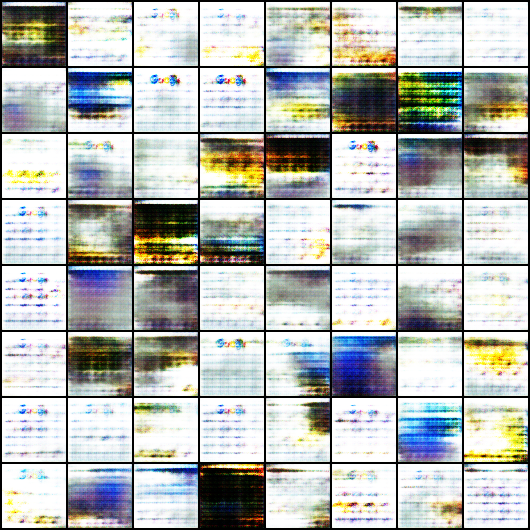

In [46]:
Image('./generated/generated-images-0001.png')